In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
import math
import time
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
print(now_str())

[03/31 23:18:10]


# Setup

In [34]:
print('torch.cuda.is_available():',torch.cuda.is_available())

device_gpu = torch.device("cuda:0")
torch.cuda.set_device(device_gpu)
device_cpu = torch.device('cpu')

print('torch.cuda.current_device():', torch.cuda.current_device())
torch.cuda.ipc_collect()
print('torch.cuda.get_device_name(0):',torch.cuda.get_device_name(0))

# print('GPU memory stats ---------------------')
# gpu_mem_stats = torch.cuda.memory_stats(device=device_gpu)
# for k, v in gpu_mem_stats.items():
#     print('  {}: {}'.format(k, v))

print(torch.cuda.memory_summary(device=device_gpu, abbreviated=False))
# Returns the current GPU memory usage by 
# tensors in bytes for a given device
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated():', bytes_alloc * 0.000001, 'Mb')

# Returns the current GPU memory managed by the
# caching allocator in bytes for a given device
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached():', bytes_cached * 0.000001, 'Mb')

bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved():', bytes_reserved * 0.000001, 'Mb')

# Releases all unoccupied cached memory currently held by
# the caching allocator so that those can be used in other
# GPU application and visible in nvidia-smi
print('----- torch.cuda.empty_cache() -----')
torch.cuda.empty_cache()
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated():', bytes_alloc * 0.000001, 'Mb')
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached():', bytes_cached * 0.000001, 'Mb')

torch.cuda.is_available(): True
torch.cuda.current_device(): 0
torch.cuda.get_device_name(0): GeForce RTX 2070 SUPER
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   29557 KB |  160062 KB |  575309 KB |  545752 KB |
|       from large pool |   28672 KB |  155648 KB |  554768 KB |  526096 KB |
|       from small pool |     885 KB |    6014 KB |   20541 KB |   19656 KB |
|---------------------------------------------------------------------------|
| Active memory         |

# Model

In [12]:
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        self.device = device
        self.image_size = kwargs.get('image_size', None)
        
        # load mesh
        mesh_path = kwargs.get('mesh_path', None)
        self.meshes = self._load_mesh(mesh_path)
        
        # load cameras
        cam_path = kwargs.get('cam_path', None)
        self.cameras = self._load_cameras(cam_path)
        
        self.renderers = self._init_renderers(self.cameras)
        
        # load texturemaps
        texturemap_shape = kwargs.get('texturemap_shape', None)
        self.texture_maps = torch.from_numpy(np.ones((1, texturemap_shape[0], texturemap_shape[1], texturemap_shape[2])).astype(np.float32)).to(self.device)
    
    def forward(self):
        image = self.renderers[0](meshes_world=self.meshes, texture_maps=self.texture_maps)
        return image
    
    def _load_cameras(self, cam_path):
        # load cameras
        cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
        with open(cam_path, 'r') as f:
            j = json.load(f)
            cam_params = j['cam_params']
            
        cameras = []
        for cam_idx, cam in enumerate(cams):
            cam_param = cam_params[str(cam_idx)]
            # for undistortion
            fx = cam_param['fx']
            fy = cam_param['fy']
            cx = cam_param['cx']
            cy = cam_param['cy']

            rvec = np.float32(cam_param['rvec'])
            T = np.float32(cam_param['tvec'])
            R, _ = cv2.Rodrigues(rvec)

            R_torch = torch.from_numpy(R.T).unsqueeze(0)
            T_torch = torch.from_numpy(T).unsqueeze(0)

            principal_point = np.array([cx, cy]).astype(np.float32)
            principal_point = torch.from_numpy(principal_point).unsqueeze(0)
            focal_length = np.array([fx, fy]).astype(np.float32)
            focal_length = torch.from_numpy(focal_length).unsqueeze(0)
            cameras.append(SfMPerspectiveCameras(device=self.device, R=R_torch, T=T_torch, principal_point=principal_point, focal_length=focal_length))
        return cameras
    
    def _load_mesh(self, mesh_path):
        # load mesh
        meshes = load_objs_as_meshes([mesh_path], device=self.device)
        return meshes
    
    def _init_renderers(self, cameras):
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
            max_faces_per_bin = None  # this setting is for coarse rasterization
        )

        renderers = []
        for i in range(len(cameras)):
            camera = cameras[i]
            cam_pos = camera.T[0]
            R = camera.R[0]
            # lights = PointLights(device=device, location=[[cam_pos[0], cam_pos[1], cam_pos[2]]], specular_color=[[0, 0, 0]])
            lights = DirectionalLights(device=self.device, direction=[[-R[0, 2], -R[1, 2], 0]], specular_color=[[0, 0, 0]])
            renderer = MeshRenderer(
                rasterizer=MeshRasterizer(
                    cameras=camera,
                    raster_settings=raster_settings
                ),
                shader=HardFlatShader(
                    device=self.device, 
                    cameras=camera,
                    lights=lights
                )
            )
            renderers.append(renderer)
        return renderers

### Test rendering

In [30]:
cam_path = r'D:\CalibrationData\CameraCalibration\2020_03_22_NewSuitDesignCapture\FinalCamParams\cam_params.json'
mesh_path = r'D:\1_Projects\200325_PyTorch3d_Toy\4_data\input\2020_03_28_SMPL_UV\SMPL_registration\SMPLFit_TPose.obj'
texturemap_shape = (1024, 1024, 3)
image_size = 1024

##### GPU

In [32]:
model_gpu = Model(device_gpu, cam_path=cam_path, mesh_path=mesh_path, texturemap_shape=texturemap_shape, image_size=image_size)

In [15]:
t0 = time.time()
image_gpu = model_gpu()
t1 = time.time()
print('{:.4f} s'.format(t1-t0))

0.4118 s


##### CPU

In [16]:
model_cpu = Model(device_cpu, cam_path=cam_path, mesh_path=mesh_path, texturemap_shape=texturemap_shape, image_size=image_size)

In [17]:
t0 = time.time()
image_cpu = model_cpu()
t1 = time.time()
print('{:.4f} s'.format(t1-t0))

104.5204 s


### visualize

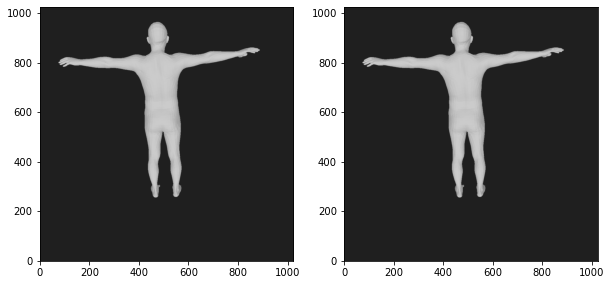

In [27]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_gpu.detach().cpu().squeeze(0).numpy())
ax[1].imshow(image_cpu.detach().cpu().squeeze(0).numpy())
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.show()